# import modules

In [1]:
import sys

sys.path.insert(0, "../")
from modules.functions_ver2 import *

# define functions

In [2]:
mcz_arr = np.linspace(10, 90, 250)


def mismatch_NP_L_plot(t_params, s_params, psd=None):
    results = {}
    ep_arr = np.zeros(len(mcz_arr))
    opt_ep_arr = np.zeros(len(mcz_arr))
    opt_ep_mcz_arr = np.zeros(len(mcz_arr))

    inst = LensingGeo(s_params)
    td = inst.td()
    I = inst.I()

    for i, mcz_L in enumerate(mcz_arr):
        s_params["mcz"] = t_params["mcz"] = mcz_L * solar_mass

        ep_NP_L = mismatch(t_params, s_params, psd=psd)["mismatch"]
        ep_arr[i] = ep_NP_L

        opt_ep_results = optimize_mismatch_mcz(t_params, s_params, psd=psd)
        opt_ep_arr[i] = opt_ep_results["ep_min"]
        opt_ep_mcz_arr[i] = opt_ep_results["ep_min_mcz"]

    ep_arr = omit_numerical_errors(ep_arr)
    results = {
        "mcz_arr": mcz_arr,
        "ep_arr": ep_arr,
        "opt_ep_arr": opt_ep_arr,
        "opt_ep_mcz_arr": opt_ep_mcz_arr,
    }

    # plot mismatch vs mcz
    plt.plot(mcz_arr, results["ep_arr"], label=r"$\epsilon$", ls="-", c="black")
    plt.plot(
        mcz_arr,
        results["opt_ep_arr"],
        label=r"$\min_{\mathcal{M}_{\rm t}}$ $\epsilon$",
        ls="--",
        c="red",
    )

    mcz_vertical = (
        (s_params["eta"] ** (3 / 5))
        / (6 ** (3 / 2) * np.pi * (20 + 1 / td))
        / solar_mass
    )
    plt.axvline(x=mcz_vertical, c="blue", ls="-", alpha=0.5)

    ep_horizontal = 1 - (1 + I) ** (-1 / 2)
    plt.axhline(y=ep_horizontal, c="grey", ls=":")

    plt.xlabel(r"$\mathcal{M}_{\text{s}}$ $[M_{\odot}]$")
    plt.ylabel(r"$\epsilon(\~h_{\rm UL}, \~h_{\rm L})$")
    plt.legend()

    # plt.title(
    #     r"$\theta_S$ = {}, $\phi_S$ = {}, $\theta_J$ = {}, $\phi_J$ = {}, {} = {:.3g} {}, $\Delta t_d$ = {:.3g} ms, $I$ = {:.3g}".format(
    #         angle_in_pi_format(s_params["theta_S"]),
    #         angle_in_pi_format(s_params["phi_S"]),
    #         angle_in_pi_format(s_params["theta_J"]),
    #         angle_in_pi_format(s_params["phi_J"]),
    #         r"$\mathcal{M}_{\rm s}$",
    #         s_params["mcz"] / solar_mass,
    #         r"$M_{\odot}$",
    #         td * 1e3,
    #         I,
    #     )
    # )

    # plt.suptitle(
    #     r"Mismatch Between Unlensed Templates & a Lensed Source Optimized Over $\mathcal{M}_{\rm t}$"
    # )

    return results

In [3]:
def predict_epsilon_critical_points(s_params):
    eta = s_params["eta"]
    inst = LensingGeo(s_params)
    td = inst.td()
    I = inst.I()
    f_min = 20

    # peaks of epsilon
    n_peak = math.ceil(f_min * td)
    mcz_peak = (eta ** (3 / 5) * td) / (6 ** (3 / 2) * np.pi * n_peak) / solar_mass
    while mcz_peak >= 10:
        if mcz_peak <= 90:
            plt.axvline(x=mcz_peak, c="pink", ls="-.")
        n_peak += 1
        mcz_peak = (eta ** (3 / 5) * td) / (6 ** (3 / 2) * np.pi * n_peak) / solar_mass

    # troughs of epsilon
    n_trough = math.ceil(f_min * td - 1 / 2)
    mcz_trough = (
        (eta ** (3 / 5) * td) / (6 ** (3 / 2) * np.pi * (n_trough + 1 / 2)) / solar_mass
    )
    while mcz_trough >= 10:
        if mcz_trough <= 90:
            plt.axvline(x=mcz_trough, c="cyan", ls=":")
        n_trough += 1
        mcz_trough = (
            (eta ** (3 / 5) * td)
            / (6 ** (3 / 2) * np.pi * (n_trough + 1 / 2))
            / solar_mass
        )

In [4]:
def predict_epsilon_flat_points(s_params):
    eta = s_params["eta"]
    inst = LensingGeo(s_params)
    td = inst.td()
    I = inst.I()
    f_min = 20

    n = 0
    mcz_flat = (
        (s_params["eta"] ** (3 / 5))
        / (6 ** (3 / 2) * np.pi * (f_min + n / td))
        / solar_mass
    )
    while mcz_flat >= 10:
        if mcz_flat <= 90:
            plt.axvline(x=mcz_flat, c="green", ls=":")
        n += 1
        mcz_flat = (
            (s_params["eta"] ** (3 / 5))
            / (6 ** (3 / 2) * np.pi * (f_min + n / td))
            / solar_mass
        )

# plot mismatch between NP templates and L source optimized over $\mathcal{M}_{\text{t}}$

y = 0.348, MLz = 2174.55 solar masses
Results saved as ../data/sys3_mismatch_NP_L_td0.03_I0.5_2024-07-23_19-46-34.pkl


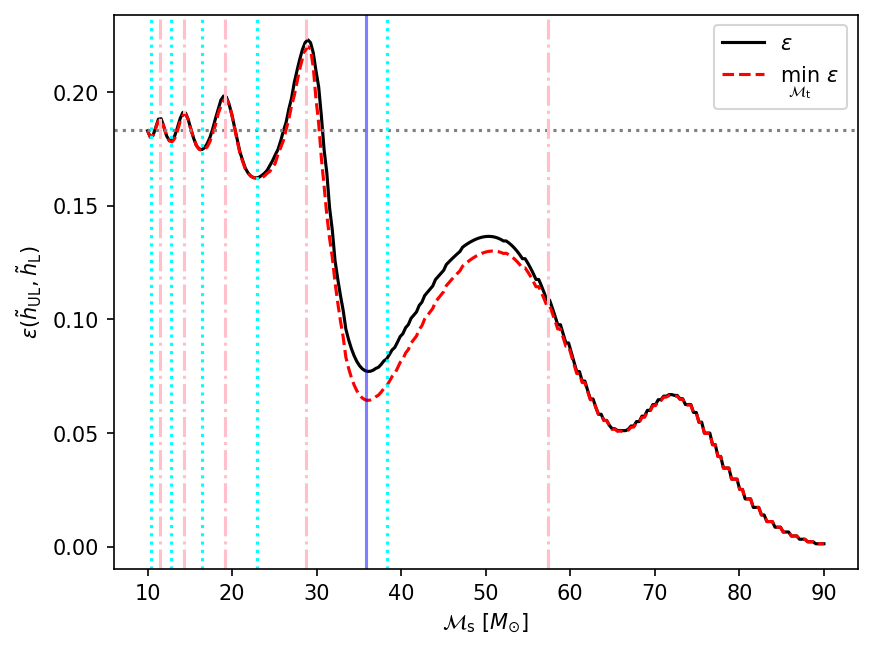

In [8]:
lens_params, NP_params = set_to_location(
    loc_params["Taman"]["random"], lens_params_1, NP_params_1
)
def_td = 0.03
def_I = 0.5
def_y = get_y_from_I(def_I)
def_MLz = get_MLz_from_td(def_td, def_y)
print("y = {:.3g}, MLz = {:.6g} solar masses".format(def_y, def_MLz))
lens_params["y"] = def_y
lens_params["MLz"] = def_MLz * solar_mass

mcz_arr = np.linspace(10, 90, 250)
mismatch_NP_L_mcz_results = mismatch_NP_L_plot(NP_params, lens_params)
pickle_data(
    mismatch_NP_L_mcz_results,
    "../data",
    "sys3_mismatch_NP_L_td{:.3g}_I{:.2g}".format(def_td, def_I),
)

predict_epsilon_critical_points(lens_params)

# plt.savefig(
#     "../figures/sys3_mismatch_mcz_td{:.3g}_I{:.2g}.pdf".format(def_td, def_I),
#     bbox_inches="tight",
# )